In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import verde as vd
import harmonica as hm
import xarray as xr
import eqs_magnetics as eqs
import synthetics
import pooch

## Project ICEGRAV Coordinates

In [2]:
# download ICEGRAV data
url = "https://ramadda.data.bas.ac.uk/repository/entry/get/ICEGRAV_Mag.XYZ?entryid=synth%3A849e2215-95b0-4275-88b8-50e18e3f8d56%3AL0lDRUdSQVZfTWFnLlhZWg%3D%3D"
file_path = pooch.retrieve(
    url=url,
    known_hash="a98d4a0e8b07b19a284ec6567fa870237e0c361820cd28db8f8b602336793a12",
)

In [3]:
icegrav = pd.read_table(
    file_path,
    # skiprows=10,
    skiprows=list(range(0, 5)) + list(range(6,11)),
    sep='\s+',
    na_values="*",
    dtype={1:str},
    header=0,
)
# get col names
col_names = icegrav.columns[1:]

# drop last column
icegrav = icegrav.iloc[:, :-1]

# use proper column names
icegrav.columns = col_names

icegrav.dropna(subset=('Lon', 'Lat'), inplace=True)
icegrav.drop(labels=['x', 'y'], axis=1, inplace=True)

In [4]:
icegrav

,Flight_ID,Line_Number,Lon,Lat,Height_WGS1984,Date,Time,MagR,MagC,TCorr,...,MagRTC,BCorr_FD83,BCorr_Halley,BCorr_Applied,MagBRTC,ACorr,SCorr,MagF,MagL,MagML
0,15.00,100,17.666285,-83.314112,2689.4,2013/01/26,08:42:20.00,50618.44,50677.36,-142.0,...,320.24,197.74,-28.68,197.74,122.50,NaN,NaN,NaN,69.84,54.09
1,15.00,100,17.661398,-83.314174,2689.5,2013/01/26,08:42:21.00,50617.95,50677.00,-142.0,...,320.08,197.71,-28.68,197.71,122.37,52.63,NaN,69.74,69.73,54.03
2,15.00,100,17.656513,-83.314235,2689.6,2013/01/26,08:42:22.00,50617.64,50676.73,-142.0,...,320.00,197.68,-28.69,197.68,122.32,52.64,NaN,69.69,69.60,53.96
3,15.00,100,17.651631,-83.314296,2689.8,2013/01/26,08:42:23.00,50617.10,50676.25,-142.0,...,319.72,197.64,-28.69,197.64,122.08,52.65,NaN,69.43,69.48,53.87
4,15.00,100,17.646752,-83.314355,2689.9,2013/01/26,08:42:24.00,50616.83,50675.94,-142.0,...,319.60,197.60,-28.70,197.60,122.00,52.66,NaN,69.34,69.34,53.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404564,10.00,10480,-27.993470,-78.733044,1589.9,2013/01/17,12:11:37.00,45832.18,45858.08,0.0,...,109.35,NaN,-29.12,-29.12,138.46,27.87,NaN,110.59,88.93,NaN
404565,10.00,10480,-27.994831,-78.733557,1588.7,2013/01/17,12:11:38.00,45832.61,45858.58,0.0,...,109.33,NaN,-29.12,-29.12,138.45,27.94,NaN,110.51,88.93,NaN
404566,10.00,10480,-27.996154,-78.734072,1587.2,2013/01/17,12:11:39.00,45832.81,45858.92,0.0,...,109.15,NaN,-29.12,-29.12,138.27,28.01,NaN,110.26,88.93,NaN
404567,10.00,10480,-27.997440,-78.734590,1585.4,2013/01/17,12:11:40.00,45833.40,45859.53,0.0,...,109.24,NaN,-29.13,-29.13,138.37,28.07,NaN,110.29,88.92,NaN


In [5]:
projection = pyproj.Proj(projparams='+proj=ups +south', preserve_units=False)
x,y = projection(icegrav.Lon, icegrav.Lat)
icegrav.insert(4, 'x', np.transpose(x))
icegrav.insert(5, 'y', np.transpose(y))
icegrav

,Flight_ID,Line_Number,Lon,Lat,x,y,Height_WGS1984,Date,Time,MagR,...,MagRTC,BCorr_FD83,BCorr_Halley,BCorr_Applied,MagBRTC,ACorr,SCorr,MagF,MagL,MagML
0,15.00,100,17.666285,-83.314112,2.225511e+06,2.708058e+06,2689.4,2013/01/26,08:42:20.00,50618.44,...,320.24,197.74,-28.68,197.74,122.50,NaN,NaN,NaN,69.84,54.09
1,15.00,100,17.661398,-83.314174,2.225449e+06,2.708070e+06,2689.5,2013/01/26,08:42:21.00,50617.95,...,320.08,197.71,-28.68,197.71,122.37,52.63,NaN,69.74,69.73,54.03
2,15.00,100,17.656513,-83.314235,2.225386e+06,2.708083e+06,2689.6,2013/01/26,08:42:22.00,50617.64,...,320.00,197.68,-28.69,197.68,122.32,52.64,NaN,69.69,69.60,53.96
3,15.00,100,17.651631,-83.314296,2.225324e+06,2.708096e+06,2689.8,2013/01/26,08:42:23.00,50617.10,...,319.72,197.64,-28.69,197.64,122.08,52.65,NaN,69.43,69.48,53.87
4,15.00,100,17.646752,-83.314355,2.225261e+06,2.708109e+06,2689.9,2013/01/26,08:42:24.00,50616.83,...,319.60,197.60,-28.70,197.60,122.00,52.66,NaN,69.34,69.34,53.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404564,10.00,10480,-27.993470,-78.733044,1.411041e+06,3.107976e+06,1589.9,2013/01/17,12:11:37.00,45832.18,...,109.35,NaN,-29.12,-29.12,138.46,27.87,NaN,110.59,88.93,NaN
404565,10.00,10480,-27.994831,-78.733557,1.411041e+06,3.107911e+06,1588.7,2013/01/17,12:11:38.00,45832.61,...,109.33,NaN,-29.12,-29.12,138.45,27.94,NaN,110.51,88.93,NaN
404566,10.00,10480,-27.996154,-78.734072,1.411043e+06,3.107846e+06,1587.2,2013/01/17,12:11:39.00,45832.81,...,109.15,NaN,-29.12,-29.12,138.27,28.01,NaN,110.26,88.93,NaN
404567,10.00,10480,-27.997440,-78.734590,1.411045e+06,3.107782e+06,1585.4,2013/01/17,12:11:40.00,45833.40,...,109.24,NaN,-29.13,-29.13,138.37,28.07,NaN,110.29,88.92,NaN


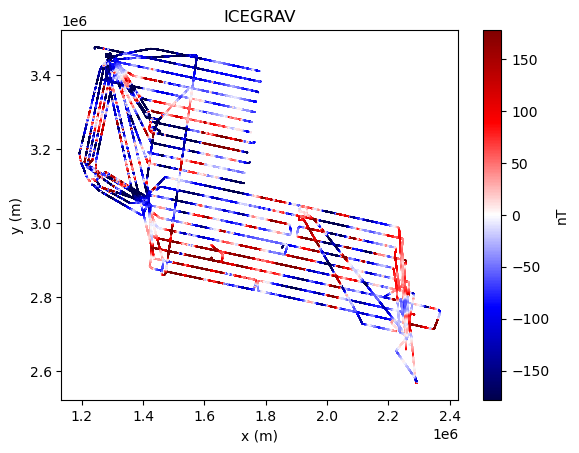

In [6]:
plt.figure()
scale = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(icegrav.x, icegrav.y, c=icegrav.MagL, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
plt.title("ICEGRAV")
plt.show()

In [7]:
icegrav.to_csv('../data/icegrav.csv', index=False)

## Synthetic

In [ ]:
synthetic = icegrav[(icegrav['x'] >= 1.9e6) & (icegrav['y'] <= 3.1e6)]
synthetic.reset_index(inplace=True)
coordinates = [synthetic.x, synthetic.y, synthetic.Height_WGS1984]
field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 35)]).T
source_coordinates, dipole_moments = synthetics.icegrav_synthetic(
    source1=[75,60],
    source2=[-60,45],
    source3=[50,70],
    source4=[-70,40],
    dyke1=[-70,80],
    dyke2=[-70,80],
    dipoles=[45,-65],
    regional_dipole=[55,45],
    regional=[-50,40]   
)
b_synthetic = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)
tfa_synthetic = eqs.total_field_anomaly(b_synthetic, field_direction)
bnorm_synthetic = eqs.magnetic_field_norm(b_synthetic)

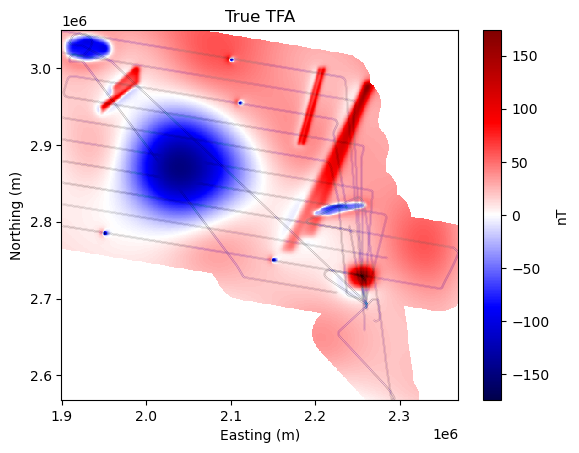

In [9]:
grid_coordinates = vd.grid_coordinates(vd.get_region(coordinates), spacing=1e3, extra_coords=3e3)
mask = vd.distance_mask(data_coordinates=coordinates, maxdist=3e4, coordinates=grid_coordinates)
# mask = vd.convexhull_mask(coordinates, grid_coordinates)
grid_coords_masked = (
    np.array((xr.DataArray(grid_coordinates[0])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[1])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[2])).where(mask, drop=False))
)
true_b = eqs.dipole_magnetic(grid_coords_masked, source_coordinates, dipole_moments)
true_tfa = eqs.total_field_anomaly(true_b, field_direction)
plt.figure()
scale = vd.maxabs(true_tfa)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="seismic", vmin=-scale, vmax=scale)
plt.plot(*coordinates[:2], '.', markersize=0.005)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

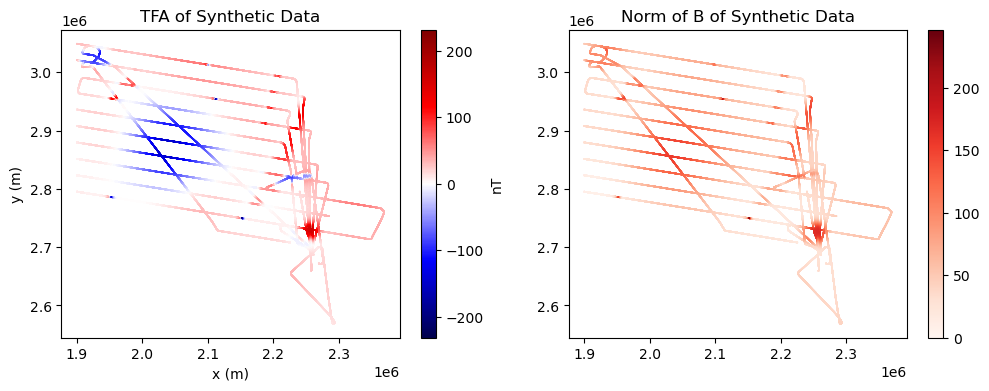

In [10]:
plt.figure(figsize=(12,4))
scale = vd.maxabs(tfa_synthetic)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_synthetic, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
scale = vd.maxabs(bnorm_synthetic)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm_synthetic, cmap="Reds",s=0.01, vmin=0, vmax=scale)
plt.title("Norm of B of Synthetic Data")
plt.colorbar()
plt.show()

In [11]:
icegrav_synthetic = pd.DataFrame(np.transpose(b_synthetic), columns= ['b_x','b_y','b_u'])
icegrav_synthetic.insert(0, 'x', np.transpose(coordinates[0]))
icegrav_synthetic.insert(1, 'y', np.transpose(coordinates[1]))
icegrav_synthetic.insert(2, 'u', np.transpose(coordinates[2]))
icegrav_synthetic.insert(6, 'tfa', np.transpose(tfa_synthetic))
icegrav_synthetic.insert(7, 'bnorm', np.transpose(bnorm_synthetic))
icegrav_synthetic.to_csv('../data/icegrav_synthetic.csv', index=False)

In [12]:
icegrav_synthetic_sources = pd.DataFrame(np.transpose(source_coordinates), columns= ['x','y','u'])
icegrav_synthetic_sources.insert(3, 'dipole_moment_x', np.transpose(dipole_moments[0]))
icegrav_synthetic_sources.insert(4, 'dipole_moment_y', np.transpose(dipole_moments[1]))
icegrav_synthetic_sources.insert(5, 'dipole_moment_u', np.transpose(dipole_moments[2]))
icegrav_synthetic_sources.to_csv('../data/icegrav_synthetic_sources.csv', index=False)

In [13]:
icegrav_synthetic_sources

,x,y,u,dipole_moment_x,dipole_moment_y,dipole_moment_u
0,1.910000e+06,3.015000e+06,-6000.000000,2.241439e+09,1.294095e+09,-9.659258e+09
1,1.912105e+06,3.015000e+06,-6000.000000,2.241439e+09,1.294095e+09,-9.659258e+09
2,1.914211e+06,3.015000e+06,-6000.000000,2.241439e+09,1.294095e+09,-9.659258e+09
3,1.916316e+06,3.015000e+06,-6000.000000,2.241439e+09,1.294095e+09,-9.659258e+09
4,1.918421e+06,3.015000e+06,-6000.000000,2.241439e+09,1.294095e+09,-9.659258e+09
...,...,...,...,...,...,...
9209,2.281044e+06,3.100003e+06,-68534.019661,2.065880e+12,2.462019e+12,3.830222e+12
9210,2.298272e+06,3.099995e+06,-71369.255881,2.065880e+12,2.462019e+12,3.830222e+12
9211,2.315510e+06,3.099993e+06,-72107.789063,2.065880e+12,2.462019e+12,3.830222e+12
9212,2.332772e+06,3.100002e+06,-70594.285962,2.065880e+12,2.462019e+12,3.830222e+12


In [14]:
# grid_coordinates = vd.grid_coordinates([-84.4,-75.0,-35.2,27.6], spacing=0.05, extra_coords=3e3)
# plt.figure()
# plt.scatter(grid_coordinates[1], grid_coordinates[0], c=grid_coordinates[2], cmap="viridis",s=0.005)
# plt.plot(icegrav.Lon, icegrav.Lat, '.', markersize=0.005)
# plt.xlabel("Lon (m)")
# plt.ylabel("Lat (m)")
# plt.colorbar(label="nT")
# plt.title("ICEGRAV")
# plt.show()

In [15]:
# df = pd.DataFrame(grid_coordinates[0].ravel(), columns= ['Lat'])
# df.insert(1, 'Lon', np.transpose(grid_coordinates[1].ravel()))
# df.insert(2, 'Height', np.transpose(grid_coordinates[2].ravel()))
# df.to_csv('icegrav_grid.txt', index=False)